<a id='top'></a>
<h1 style="text-align:center;font-size:200%;;">Real or Not? NLP with Disaster Tweets</h1>
<img src="https://dataxboost.files.wordpress.com/2018/03/nlp.jpg">

## Competition Description
* Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Notebook Content!</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#libraries" role="tab" aria-controls="profile">Import Libraries<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#load" role="tab" aria-controls="messages">Load Data<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#visual" role="tab" aria-controls="settings">Visualization of data<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#word" role="tab" aria-controls="settings">WordCloud<span class="badge badge-primary badge-pill">4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#clean" role="tab" aria-controls="settings">Cleaning the text<span class="badge badge-primary badge-pill">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#split" role="tab" aria-controls="settings">Train and test Split<span class="badge badge-primary badge-pill">6</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#model" role="tab" aria-controls="settings"> Creating the Model<span class="badge badge-primary badge-pill">7</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#eval" role="tab" aria-controls="settings">Model Evaluation<span class="badge badge-primary badge-pill">8</span></a>  

<a id='libraries'></a>
## 1. Import Libraries

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit 
import nltk  
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
cf.go_offline()

<a id='load'></a>
# 2. Load Data

In [8]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission =  pd.read_csv("data/sample_submission.csv")

In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<ul style="list-style-type:square;">
  <li><span class="label label-default">id</span> a unique identifier for each tweet</li>
  <li><span class="label label-default">text </span> the text of the tweet</li>
  <li><span class="label label-default">location</span>  the location the tweet was sent from (may be blank)</li>
    <li><span class="label label-default">keyword</span>  a particular keyword from the tweet (may be blank)</li>
    <li><span class="label label-default">target</span>  in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)</li>
</ul>


In [10]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
display(HTML(f"""
   
        <ul class="list-group">
          <li class="list-group-item disabled" aria-disabled="true"><h4>Shape of Train and Test Dataset</h4></li>
          <li class="list-group-item"><h4>Number of rows in Train dataset is: <span class="label label-primary">{ train.shape[0]:,}</span></h4></li>
          <li class="list-group-item"> <h4>Number of columns Train dataset is <span class="label label-primary">{train.shape[1]}</span></h4></li>
          <li class="list-group-item"><h4>Number of rows in Test dataset is: <span class="label label-success">{ test.shape[0]:,}</span></h4></li>
          <li class="list-group-item"><h4>Number of columns Test dataset is <span class="label label-success">{test.shape[1]}</span></h4></li>
        </ul>
  
    """))

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<a id='visual'></a>
# 3. Visualization of data

In [15]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).iplot(kind='bar',title='Null values present in train Dataset', color=['red'])

In [16]:
train.target.value_counts().iplot(kind='bar',text=['Fake', 'Real'], title='Comparing Tweet is a real disaster (1) or not (0)',color=['blue'])

In [18]:
counts_train = train.target.value_counts(sort=False)
labels = counts_train.index
values_train = counts_train.values

data = go.Pie(labels=labels, values=values_train ,pull=[0.03, 0])
layout = go.Layout(title='Comparing Tweet is a real disaster (1) or not (0) in %')

fig = go.Figure(data=[data], layout=layout)
fig.update_traces(hole=.3, hoverinfo="label+percent+value")
fig.update_layout(
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Train', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [19]:
train['length'] = train['text'].apply(len)

In [21]:
data = [
    go.Box(
        y=train[train['target']==0]['length'],
        name='Fake'
    ),
    go.Box(
        y=train[train['target']==1]['length'],
        name='Real'
    )
]
layout = go.Layout(
    title = 'Comparison of text length in Tweets '
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [22]:
train.keyword.nunique()  # Total of 221 unique keywords

221

In [23]:

train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')

In [24]:
train.location.value_counts()[:20].iplot(kind='bar', title='Top 20 location in tweet', color='blue')  # Check the top 15 locations 

 <a id='word'></a>
#  4. WordCloud

In [25]:
STOPWORDS.add('https')  # remove https to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

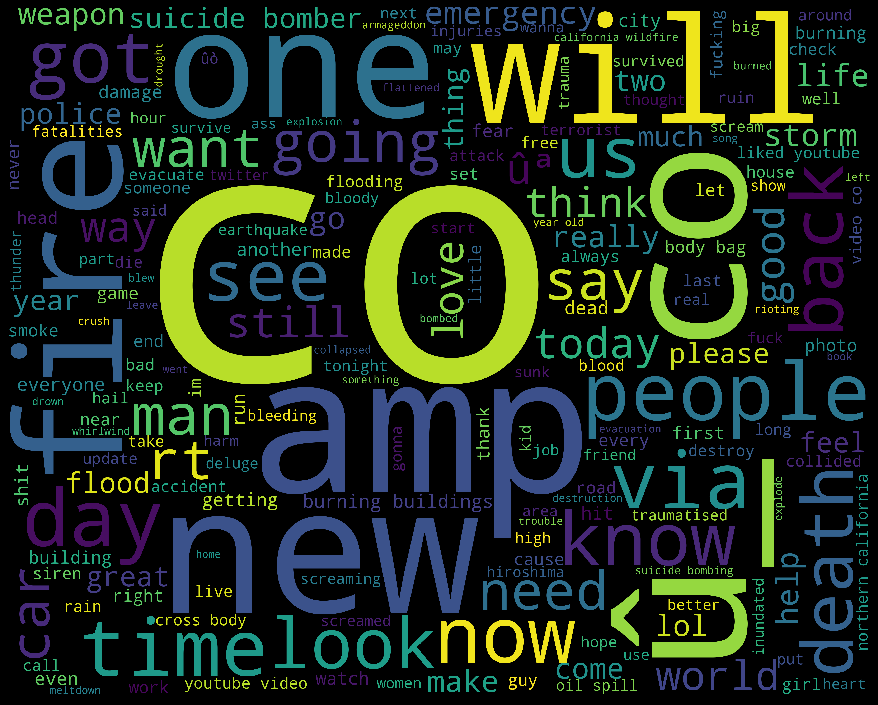

In [26]:
text = train.text.values

Plot_world(text)


<a id='clean'></a>
# 5. Cleaning the text

In [27]:
#How many http words has this text?
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [28]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [29]:
# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [30]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].target.value_counts()

0    1
Name: target, dtype: int64

In [31]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

### Now remove stopwords, pass to lower add delimiter and more

In [32]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

In [33]:
text = train.text[3]
print(text)
clean_text(text)

13,000 people receive #wildfires evacuation orders in California 


'people receive wildfires evacuation orders california'

In [34]:
# Apply clean text 
train['text'] = train['text'].apply(lambda x : clean_text(x))

In [35]:
# Apply clean text 
test['text']=test['text'].apply(lambda x : clean_text(x))

In [36]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [37]:
text_values = train["text"]

counter = counter_word(text_values)

In [38]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

<a id='split'></a>
# 6. Train Test Split

In [39]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [40]:
# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]

In [41]:

print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)


The Shape of training  (6090,)
The Shape of testing (1523,)


In [42]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)


In [43]:
word_index = tokenizer.word_index

In [44]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

# If you want to see completed -> word_index

THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 
 one,  11 
 disaster,  12 
 body,  13 
 video,  14 
 burning,  15 


In [45]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [47]:
print(train.text[1])
print(training_sequences[1])
print(training_padded[1])

forest fire near la ronge sask canada
[74, 4, 120, 571, 5480, 5481, 1184]
[  74    4  120  571 5480 5481 1184    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## check Inverse for see how it works

In [48]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


In [49]:
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

# If you want to see completed -> reverse_word_index

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  via 
 7,  new 
 8,  people 
 9,  news 
 10,  emergency 
 11,  one 
 12,  disaster 
 13,  body 
 14,  video 
 15,  burning 


In [50]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [51]:
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [52]:
training_padded[1628]

array([7779, 1150, 2107,  629, 2106, 1257,   52,  326, 2106, 1257,   52,
        326, 7780,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [53]:

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



<a id='model'></a>
# 7. Creating the Model

    # For a binary classification problem
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
                                    

In [54]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [55]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            514240    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 565,725
Trainable params: 565,725
Non-trainable params: 0
_________________________________________________________________


In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [67]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')


Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 6s 919us/sample - loss: 0.5801 - accuracy: 0.6798 - val_loss: 0.4871 - val_accuracy: 0.7597
Epoch 2/10
6090/6090 [==============================] - 3s 421us/sample - loss: 0.3192 - accuracy: 0.8729 - val_loss: 0.5074 - val_accuracy: 0.7321
Epoch 3/10
6090/6090 [==============================] - 3s 431us/sample - loss: 0.1823 - accuracy: 0.9392 - val_loss: 0.6727 - val_accuracy: 0.7209
Epoch 4/10
6090/6090 [==============================] - 3s 430us/sample - loss: 0.1224 - accuracy: 0.9603 - val_loss: 0.6094 - val_accuracy: 0.7446
Epoch 5/10
6090/6090 [==============================] - 3s 430us/sample - loss: 0.0961 - accuracy: 0.9701 - val_loss: 0.8695 - val_accuracy: 0.6861
Epoch 6/10
6090/6090 [==============================] - 2s 409us/sample - loss: 0.0823 - accuracy: 0.9732 - val_loss: 0.9027 - val_accuracy: 0.7157
Epoch 7/10
6090/6090 [==============================] - 3s 423us

In [68]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.580115,0.679803,0.487098,0.759685
1,0.319186,0.872906,0.507413,0.732108
2,0.182306,0.939245,0.672726,0.720945
3,0.122356,0.960263,0.609409,0.744583
4,0.096077,0.970115,0.869477,0.686146


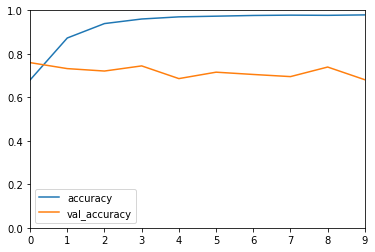

In [69]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

<a id='eval'></a>
# 8. Model Evaluation

In [70]:
predictions = model.predict_classes(testing_padded)   # predict_ clases because is classification problem with the split test

In [71]:
predictions

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [72]:
from sklearn.metrics import classification_report,confusion_matrix

In [73]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

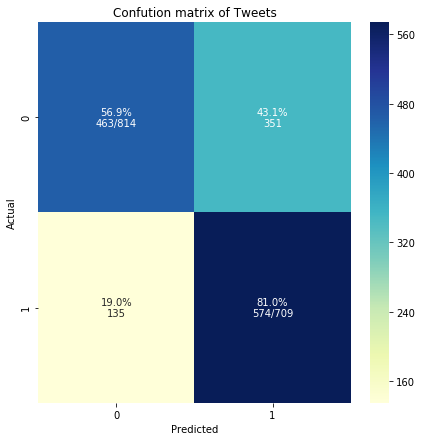

In [74]:
# Showing Confusion Matrix
plot_cm(testing_labels,predictions, 'Confution matrix of Tweets', figsize=(7,7))

# Now working with test dataset

In [75]:

testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [76]:
predictions = model.predict(testing_padded2)

In [77]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [78]:
submission['target'] = (predictions > 0.5).astype(int)

In [79]:
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [80]:
submission.to_csv("submission.csv", index=False, header=True)

<h2>I hope this notebook <span style="color:red">Usefull</span> for you! </h3>

<a href="#top" class="btn btn-primary btn-lg active" role="button" aria-pressed="true">Go to TOP</a>
